# Downloading Dataset and Augmenting it

In [1]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import exposure
import csv
from pathlib import Path
from data_read_write import read_image, read_dataset
from preprocessing import preprocess
from plotting import showInRow

## Parameters

In [9]:
DATASET_DIR = Path("Dataset")
DATASET_DIR.mkdir(exist_ok=True)

TRAIN_IMAGES_PATH = DATASET_DIR / "GTSRB/Final_Training/Images"

TRAIN_DIR = DATASET_DIR / "Train_cluster"
TRAIN_DIR.mkdir(exist_ok=True)

TAIN_LABELS = TRAIN_DIR /"labels.csv"

CLASS_MIN_SIZE = 100

### Download and unzip dataset

In [40]:
from IPython.display import clear_output
!wget -O training_data.zip https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget -O testing_data.zip https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget -O test_labels.zip https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
clear_output() 

import zipfile
zip_files = ["training_data.zip", "testing_data.zip", "test_labels.zip"]
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

### Read train data and augment images from one video tracks

In [12]:
def create_train_dataset(data_dir, dest_dir, class_min_amount):
    class_dirs = data_dir.glob("*/")
    classes = {}
    for class_dir in class_dirs:
        class_label = int(class_dir.name)
        image_files = list(class_dir.glob("*.ppm"))
        tracks = {}
        for image_file in image_files:
            track_id = int(image_file.name.split("_")[0])
            if not track_id in tracks:
                tracks[track_id] = []
            tracks[track_id].append(image_file)
        classes[class_label] = tracks
        
    image_classes = {}
    for class_id, data in classes.items():
        tracks = {}
        for track_id, image_paths in data.items():
            images = []
            for image_path in image_paths:
                images.append(read_image(image_path))
            images = sorted(images, key=lambda x: x.shape[0], reverse=True)
            tracks[track_id] = images
        image_classes[class_id] = tracks
        
    uniform_classes = {}
    for class_id, data in image_classes.items():
        class_images = []
        per_track = class_min_amount//len(data.keys())+1
        for track_id, images in data.items():
            collected = 0
            if per_track > len(images):
                class_images += images
                collected += len(images)
                i = 0
                while collected < per_track:
                    class_images.append(images[i])
                    collected += 1
                    if i >= len(images):
                        i = 0
            else:
                class_images += images[:per_track]
        uniform_classes[class_id] = class_images
        
        
    i = 0
    scv_clmns = ["Filename", "ClassId"]
    dict_data = []
    labels_file = "labels.csv"

    for class_id, images in uniform_classes.items():
        for image in images:
            name = str(i) + ".ppm"
            dict_data.append({"Filename":name, "ClassId": int(class_id)})
            image = preprocess(image, augment=True)
            if image.dtype != np.uint8:
                image = image * 255
                image = image.astype(np.uint8)

            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(str(dest_dir / name),image)
            i+=1

    with open(dest_dir/labels_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=scv_clmns)
        writer.writeheader()
        for data in dict_data:
            writer.writerow(data)

In [13]:
create_train_dataset(data_dir=TRAIN_IMAGES_PATH,
                     dest_dir=TRAIN_DIR,
                     class_min_amount=CLASS_MIN_SIZE)

In [3]:
train_X, train_y = read_dataset(TRAIN_DIR, labels_file=TAIN_LABELS,
                                img_shape=(24,24))

In [4]:
len(train_X)

22198

In [5]:
test_X, test_y = read_dataset(Path("Dataset/GTSRB/Final_Test/Images"), 
                              labels_file="Dataset/GT-final_test.csv",
                              delimiter=";")

In [6]:
len(test_X)

12630

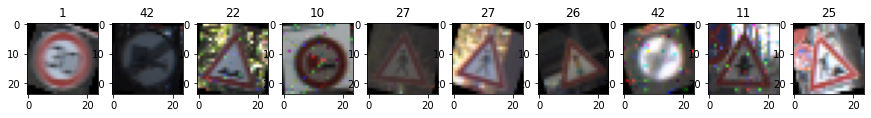

In [7]:
showInRow(train_X[:10], train_y[:10])

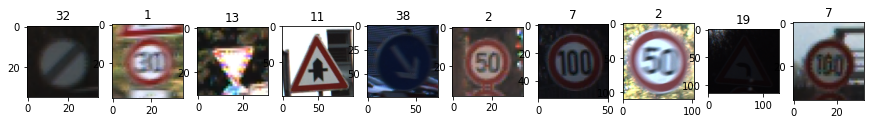

In [8]:
showInRow(test_X[:10],test_y[:10])